In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import chart_studio.plotly as py
import plotly.express as px
from plotly.offline import download_plotlyjs ,init_notebook_mode ,plot ,iplot
init_notebook_mode(connected=True)
import sort_dataframeby_monthorweek as sd

# Train Test Split
from sklearn.model_selection import train_test_split

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_csv('hotel_bookings.csv')

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


In [4]:
df.shape

(119390, 32)

In [5]:
# this data is for 2 hotels
df['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [6]:
# we have binary classification problem, we want to predict if the booking will be canceled or not!
df['is_canceled'].unique()

array([0, 1], dtype=int64)

# Data Cleaning

In [7]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

## Missing Values

As we can observe we have four columns with missing values. The columns agent and company have many missing values and the columns country and children have few so for the last 2 columns we will try to fill in these missing values.
<br>However for the columns agent and company I will drop these columns because they are **id columns**.

**agent**=ID the travel agency that made the booking<br>
**company**=ID the company/entity that made the booking or is responsible for paying the booking. ID is presented instead of designation for anonymity reasons

In [8]:
#drop the columns agent , company as mention above
df.drop(['agent','company'],axis=1,inplace=True)

In [9]:
#fill the missing values using the mode of the columns, in this case the PRT
df['country'].value_counts()

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: country, Length: 177, dtype: int64

In [10]:
df['country'].fillna(df['country'].value_counts().index[0], inplace=True)

In [11]:
#we have only 4 missing values for the column children. I decide to fill them with 0 because are only few
df.fillna(0,inplace=True)

In [12]:
#now we handle all missing values
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

## Remove Irrelevant Data

As we can observe we have 3 columns: adults, children, and babies. If all these columns are 0 the booking shouldn't be possible!
So let's see if this combination exists in our data and if exists we should drop these rows

In [13]:
filter1 = (df['adults']==0) & (df['children']==0) & (df['babies']==0)

In [14]:
#we have 180 rows where adults, children and babies are 0 in the same row
df[filter1]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2224,Resort Hotel,0,1,2015,October,41,6,0,3,0,0.0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,1,No Deposit,0,Transient-Party,0.00,0,0,Check-Out,10/6/2015
2409,Resort Hotel,0,0,2015,October,42,12,0,0,0,0.0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,0,No Deposit,0,Transient,0.00,0,0,Check-Out,10/12/2015
3181,Resort Hotel,0,36,2015,November,47,20,1,2,0,0.0,0,SC,ESP,Groups,TA/TO,0,0,0,A,C,0,No Deposit,0,Transient-Party,0.00,0,0,Check-Out,11/23/2015
3684,Resort Hotel,0,165,2015,December,53,30,1,4,0,0.0,0,SC,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,122,Transient-Party,0.00,0,0,Check-Out,1/4/2016
3708,Resort Hotel,0,165,2015,December,53,30,2,4,0,0.0,0,SC,PRT,Groups,TA/TO,0,0,0,A,C,1,No Deposit,122,Transient-Party,0.00,0,0,Check-Out,1/5/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115029,City Hotel,0,107,2017,June,26,27,0,3,0,0.0,0,BB,CHE,Online TA,TA/TO,0,0,0,A,A,1,No Deposit,0,Transient,100.80,0,0,Check-Out,6/30/2017
115091,City Hotel,0,1,2017,June,26,30,0,1,0,0.0,0,SC,PRT,Complementary,Direct,0,0,0,E,K,0,No Deposit,0,Transient,0.00,1,1,Check-Out,7/1/2017
116251,City Hotel,0,44,2017,July,28,15,1,1,0,0.0,0,SC,SWE,Online TA,TA/TO,0,0,0,A,K,2,No Deposit,0,Transient,73.80,0,0,Check-Out,7/17/2017
116534,City Hotel,0,2,2017,July,28,15,2,5,0,0.0,0,SC,RUS,Online TA,TA/TO,0,0,0,A,K,1,No Deposit,0,Transient-Party,22.86,0,1,Check-Out,7/22/2017


In [15]:
#we drop the above columns
df_cleaned = df[~filter1]

In [16]:
df_cleaned.shape

(119210, 30)

# EDA

## 1. Where do the quests come from?


In [17]:
# first we have to filter the bookings which canceled and then count the no. of quest for each county
country_df = df_cleaned[df_cleaned['is_canceled']==0]['country'].value_counts().reset_index()
country_df.columns = ['country','no_of_guests']
country_df

,country,no_of_guests
0,PRT,21398
1,GBR,9668
2,FRA,8468
3,ESP,6383
4,DEU,6067
...,...,...
160,BHR,1
161,DJI,1
162,MLI,1
163,NPL,1


In [18]:
map_guest=px.choropleth(country_df,
             locations=country_df['country'],
             color=country_df['no_of_guests'],
              hover_name=country_df['country'],
              title='Home Country of Guests'
             )

In [19]:
map_guest.show()

**Conclusion** guests from all over the world are staying in these two hotels. Most guests are from Portugal and other countries in Europe

## 2. How much do guests pay for a room per night ?

Both hotels have different room types and different meal arrangements. Seasonal factors are also important. So the prices vary a lot. Since no currency information is given, but Portugal is part of the European Monetary Union, I assume that all prices are in EUR.

In [20]:
no_canceled =df_cleaned[df_cleaned['is_canceled']==0]

In [21]:
no_canceled['reserved_room_type'].unique()

array(['C', 'A', 'D', 'G', 'E', 'F', 'H', 'L', 'B'], dtype=object)

[Text(0.5, 1.0, 'Price (EUR) of room types per night and person')]

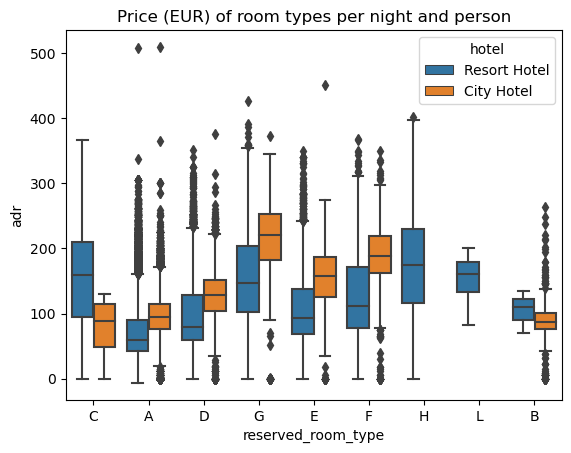

In [22]:

sns.boxplot(x='reserved_room_type',y='adr' ,hue='hotel',data=no_canceled).set(title='Price (EUR) of room types per night and person')


This figure shows the average price per room, depending on its type and the standard deviation. We can see the mean price for each room type for each hotel. Also, we can detect possible outliers

## 3. Which are the most busy month

In [23]:
# As we know we have 2 hotels, so we have to create two new dfs sorts and count the months 
# and then merge them to create a plot
df_cleaned['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [24]:
data_resort=df_cleaned[(df_cleaned['hotel']=='Resort Hotel') & (df_cleaned['is_canceled']==0)]
data_city = df_cleaned[(df_cleaned['hotel']=='City Hotel') & (df_cleaned['is_canceled']==0)]

In [25]:
# create a new df counting and sorting the guests per month
cou_resort=data_resort['arrival_date_month'].value_counts().reset_index()
cou_resort.columns=['month','no_of_guests']
cou_resort

,month,no_of_guests
0,August,3257
1,July,3137
2,October,2575
3,March,2571
4,April,2550
5,May,2535
6,February,2308
7,September,2102
8,June,2037
9,December,2014


In [26]:
# do the same for the other hotel
cou_city=data_city['arrival_date_month'].value_counts().reset_index()
cou_city.columns=['month','no_of_guests']
cou_city

,month,no_of_guests
0,August,5367
1,July,4770
2,May,4568
3,June,4358
4,October,4326
5,September,4283
6,March,4049
7,April,4010
8,February,3051
9,November,2676


In [27]:
# merge the 2 df
final=cou_resort.merge(cou_city,on='month')
final.columns=['month','no_of_guests_in_resort','no_of_guests_city']
final

,month,no_of_guests_in_resort,no_of_guests_city
0,August,3257,5367
1,July,3137,4770
2,October,2575,4326
3,March,2571,4049
4,April,2550,4010
5,May,2535,4568
6,February,2308,3051
7,September,2102,4283
8,June,2037,4358
9,December,2014,2377


In [28]:
# In order to analyze the demand for these hotels we should sort this df by month
final=sd.Sort_Dataframeby_Month(final,'month')

In [29]:
final

,month,no_of_guests_in_resort,no_of_guests_city
0,January,1866,2249
1,February,2308,3051
2,March,2571,4049
3,April,2550,4010
4,May,2535,4568
5,June,2037,4358
6,July,3137,4770
7,August,3257,5367
8,September,2102,4283
9,October,2575,4326


In [30]:
px.line(data_frame=final,x='month',y=['no_of_guests_in_resort', 'no_of_guests_city'])

**Conclusion** This clearly shows that the prices in the Resort hotel are much higher during the summer as summer is the high season, The price of the city hotel varies less and is most expensive during spring and autumn.

# Data Preprocessing

## Feature Engineering

observing our data we can use the columns adults children and babies to create a new column called family. If there 1 or more adults and at least 1 child or babie we can call them as family

In [31]:
def family(row):
    if (row['adults']>0) &  (row['children']>0 or row['babies']>0) :
        return 1
    else:
        return 0

In [32]:
df_cleaned['is_family']=df_cleaned.apply(family,axis=1)

In [33]:
df_cleaned['is_family'].unique()

array([0, 1], dtype=int64)

In [34]:
df_cleaned.drop(columns=['adults', 'children', 'babies'],axis=1,inplace=True)

In [35]:
df_cleaned.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_family
0,Resort Hotel,0,342,2015,July,27,1,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,7/1/2015,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,7/1/2015,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,7/2/2015,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,7/2/2015,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,7/3/2015,0


## Feature Encoding

As we can see we have many categorical variables. We have to convert them to numerals to apply our algorithms. To make this conversion are many tactics for this dataset I will use the mean encoding.<br>
mean encoding tries to approach the problem more logically. In a nutshell, it uses the target variable as the basis to generate the new encoded feature.

In [36]:
df_cleaned.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list                int64
customer_type                      object
adr                               float64
required_car_parking_spaces       

In [37]:
# lets seperate firth the categorical and the numberic columns
cate_features=[col for col in df_cleaned.columns if df_cleaned[col].dtype=='object']
num_features=[col for col in df_cleaned.columns if df_cleaned[col].dtype!='object']

In [38]:
data_cat=df_cleaned[cate_features]
data_cat

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,7/1/2015
1,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,7/1/2015
2,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Check-Out,7/2/2015
3,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Check-Out,7/2/2015
4,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,7/3/2015
...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,August,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,9/6/2017
119386,City Hotel,August,BB,FRA,Online TA,TA/TO,E,E,No Deposit,Transient,Check-Out,9/7/2017
119387,City Hotel,August,BB,DEU,Online TA,TA/TO,D,D,No Deposit,Transient,Check-Out,9/7/2017
119388,City Hotel,August,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,9/7/2017


In [39]:
#Here we can see that on average at Resort Hotel we have more cancelations
df_cleaned.groupby(['hotel'])['is_canceled'].mean().to_dict()

{'City Hotel': 0.4178593534858457, 'Resort Hotel': 0.27767373336329815}

Now, whenever we have City Hotel, just replace it with 0.41. Wherever we have City Resort Hotel, just replace it with 0.27.

In [40]:
data_cat['cancellation']=df_cleaned['is_canceled']

In [41]:
data_cat.head()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,cancellation
0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,7/1/2015,0
1,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,7/1/2015,0
2,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Check-Out,7/2/2015,0
3,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Check-Out,7/2/2015,0
4,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,7/3/2015,0


In [42]:
#create a list with every categorical column
cols=data_cat.columns
#exclude the cancellation column
cols=cols[0:-1]
cols

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date'],
      dtype='object')

In [43]:
#mean encoding
for col in cols:
    dict2=data_cat.groupby([col])['cancellation'].mean().to_dict()
    data_cat[col]=data_cat[col].map(dict2)

In [44]:
data_cat.head()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,cancellation
0,0.277674,0.374644,0.374106,0.562958,0.153712,0.174868,0.330827,0.188186,0.28402,0.407864,0.0,0.800000,0
1,0.277674,0.374644,0.374106,0.562958,0.153712,0.174868,0.330827,0.188186,0.28402,0.407864,0.0,0.800000,0
2,0.277674,0.374644,0.374106,0.202310,0.153712,0.174868,0.391567,0.188186,0.28402,0.407864,0.0,0.985075,0
3,0.277674,0.374644,0.374106,0.202310,0.187618,0.220568,0.391567,0.445055,0.28402,0.407864,0.0,0.985075,0
4,0.277674,0.374644,0.374106,0.202310,0.367590,0.410598,0.391567,0.445055,0.28402,0.407864,0.0,0.522876,0


## Handling Outliers

Our categorical columns now are ready to be used in machine learning algorithms but before we start building our models we should deal with outliers in numerical columns

In [45]:
df_cleaned[num_features]

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_family
0,0,342,2015,27,1,0,0,0,0,0,3,0,0.00,0,0,0
1,0,737,2015,27,1,0,0,0,0,0,4,0,0.00,0,0,0
2,0,7,2015,27,1,0,1,0,0,0,0,0,75.00,0,0,0
3,0,13,2015,27,1,0,1,0,0,0,0,0,75.00,0,0,0
4,0,14,2015,27,1,0,2,0,0,0,0,0,98.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,35,30,2,5,0,0,0,0,0,96.14,0,0,0
119386,0,102,2017,35,31,2,5,0,0,0,0,0,225.43,0,2,0
119387,0,34,2017,35,31,2,5,0,0,0,0,0,157.71,0,4,0
119388,0,109,2017,35,31,2,5,0,0,0,0,0,104.40,0,0,0


In [46]:
# now lets concat the categorical columns and numeric values in our last dataset
df_ready =pd.concat([data_cat,df_cleaned[num_features]],axis=1)
df_ready

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,cancellation,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_family
0,0.277674,0.374644,0.374106,0.562958,0.153712,0.174868,0.330827,0.188186,0.28402,0.407864,0.0,0.800000,0,0,342,2015,27,1,0,0,0,0,0,3,0,0.00,0,0,0
1,0.277674,0.374644,0.374106,0.562958,0.153712,0.174868,0.330827,0.188186,0.28402,0.407864,0.0,0.800000,0,0,737,2015,27,1,0,0,0,0,0,4,0,0.00,0,0,0
2,0.277674,0.374644,0.374106,0.202310,0.153712,0.174868,0.391567,0.188186,0.28402,0.407864,0.0,0.985075,0,0,7,2015,27,1,0,1,0,0,0,0,0,75.00,0,0,0
3,0.277674,0.374644,0.374106,0.202310,0.187618,0.220568,0.391567,0.445055,0.28402,0.407864,0.0,0.985075,0,0,13,2015,27,1,0,1,0,0,0,0,0,75.00,0,0,0
4,0.277674,0.374644,0.374106,0.202310,0.367590,0.410598,0.391567,0.445055,0.28402,0.407864,0.0,0.522876,0,0,14,2015,27,1,0,2,0,0,0,0,0,98.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0.417859,0.377823,0.374106,0.202391,0.343313,0.410598,0.391567,0.445055,0.28402,0.407864,0.0,0.000000,0,0,23,2017,35,30,2,5,0,0,0,0,0,96.14,0,0,0
119386,0.417859,0.377823,0.374106,0.185848,0.367590,0.410598,0.292683,0.251603,0.28402,0.407864,0.0,0.000000,0,0,102,2017,35,31,2,5,0,0,0,0,0,225.43,0,2,0
119387,0.417859,0.377823,0.374106,0.167193,0.367590,0.410598,0.318108,0.251373,0.28402,0.407864,0.0,0.000000,0,0,34,2017,35,31,2,5,0,0,0,0,0,157.71,0,4,0
119388,0.417859,0.377823,0.374106,0.202310,0.367590,0.410598,0.391567,0.445055,0.28402,0.407864,0.0,0.000000,0,0,109,2017,35,31,2,5,0,0,0,0,0,104.40,0,0,0


In [47]:
df_ready.describe()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,cancellation,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_family
count,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000
mean,0.370766,0.370766,0.370766,0.370766,0.370766,0.370766,0.370766,0.370766,0.370766,0.370766,0.370766,0.370766,0.370766,0.370766,104.109227,2016.156472,27.163376,15.798717,0.927053,2.499195,0.031499,0.087191,0.137094,0.218799,2.321215,101.969092,0.062553,0.571504,0.076411
std,0.066212,0.033756,0.024433,0.172547,0.128967,0.085574,0.035148,0.097361,0.232585,0.065988,0.483012,0.235858,0.483012,0.483012,106.875450,0.707485,13.601107,8.781070,0.995117,1.897106,0.174663,0.844918,1.498137,0.638504,17.598002,50.434007,0.245360,0.792876,0.265656
min,0.277674,0.305016,0.244654,0.000000,0.122253,0.174868,0.292683,0.013928,0.222222,0.101045,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000
25%,0.277674,0.334451,0.374106,0.202310,0.343313,0.410598,0.330827,0.251373,0.284020,0.407864,0.000000,0.207207,0.000000,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.500000,0.000000,0.000000,0.000000
50%,0.417859,0.377823,0.374106,0.298188,0.367590,0.410598,0.391567,0.445055,0.284020,0.407864,0.000000,0.312500,0.000000,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.950000,0.000000,0.000000,0.000000
75%,0.417859,0.397029,0.374106,0.562958,0.367590,0.410598,0.391567,0.445055,0.284020,0.407864,1.000000,0.482955,1.000000,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,0.000000
max,0.417859,0.414860,0.598997,1.000000,1.000000,0.800000,0.407654,1.000000,0.993624,0.407864,1.000000,1.000000,1.000000,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,1.000000,26.000000,72.000000,18.000000,391.000000,5400.000000,8.000000,5.000000,1.000000


In [48]:
df_ready.drop(['cancellation'],axis=1,inplace=True)

we can observe that we have some outliers in variables lead time and adr, I will create a function to deal with this

<AxesSubplot:xlabel='lead_time', ylabel='Density'>

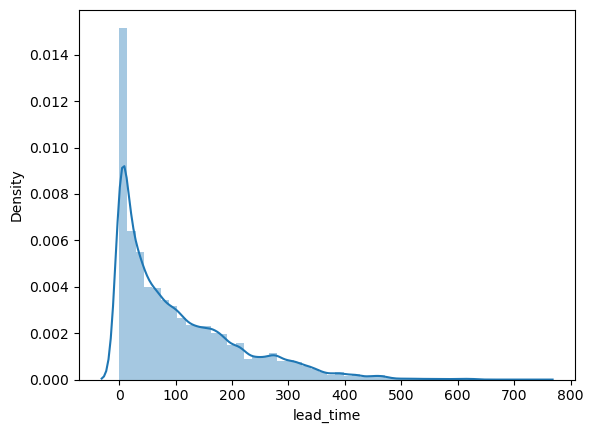

In [49]:
sns.distplot(df_ready['lead_time'])

<AxesSubplot:xlabel='adr', ylabel='Density'>

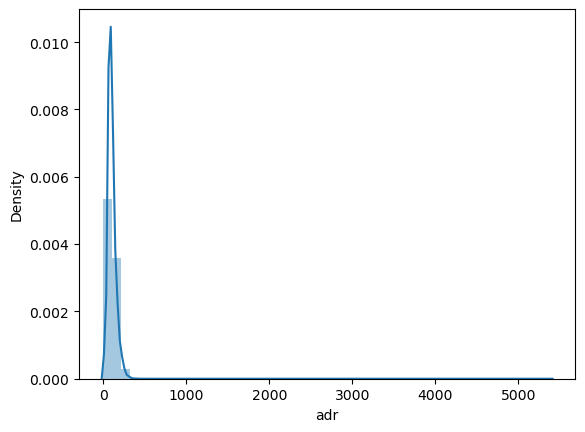

In [50]:
sns.distplot(df_ready['adr'])

In [51]:
#we use log to deal with outliers
def handle_outlier(col):
    df_ready[col]=np.log1p(df_ready[col])

In [52]:
#apply the function in lead time column
handle_outlier('lead_time')

<AxesSubplot:xlabel='lead_time', ylabel='Density'>

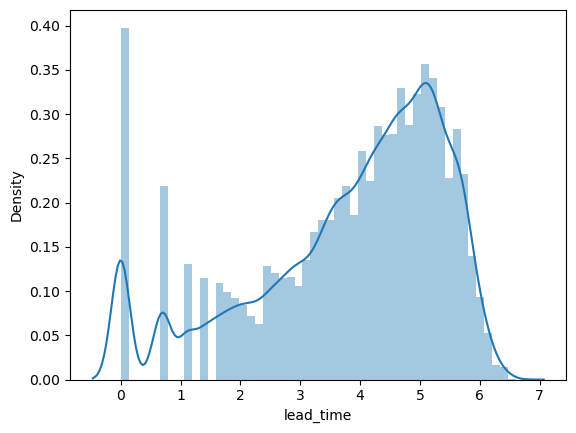

In [53]:
#re run the distplot
sns.distplot(df_ready['lead_time'])

<AxesSubplot:xlabel='adr', ylabel='Density'>

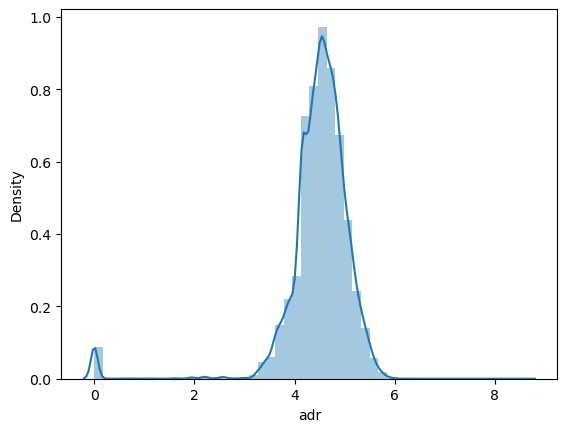

In [54]:
handle_outlier('adr')
sns.distplot(df_ready['adr'])

In [55]:
# in adr column we have a negative value so with the log we got 1 nan, so we need to drop this row!
df_ready.isnull().sum()

hotel                             0
arrival_date_month                0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
reserved_room_type                0
assigned_room_type                0
deposit_type                      0
customer_type                     0
reservation_status                0
reservation_status_date           0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               1
required_car_parking_spaces       0
total_of_special_requests         0
is_family                   

In [56]:
df_ready.dropna(how='any', inplace=True)

In [57]:
df_ready.isnull().sum()

hotel                             0
arrival_date_month                0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
reserved_room_type                0
assigned_room_type                0
deposit_type                      0
customer_type                     0
reservation_status                0
reservation_status_date           0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
is_family                   

## Correlations

Now we should investigate the correlation between our variables, we want to drop independent columns with high correlation if we find any to avoid overfitting in our models. And we want to drop columns with low correlation to lower accuracy in our models.

In [58]:
corr=df_ready.corr()
corr

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_family
hotel,1.000000,0.051181,0.061784,-0.040621,0.102616,0.182244,0.198180,0.280884,0.172794,-0.008399,0.137075,0.107480,0.137075,0.109881,0.035191,0.001227,-0.001693,-0.187789,-0.235939,-0.052468,-0.012262,-0.004452,-0.076568,0.072724,0.154041,-0.218966,-0.043487,-0.058098
arrival_date_month,0.051181,1.000000,-0.010206,-0.052417,0.047926,0.077049,-0.038794,0.015454,0.057521,-0.029658,0.069877,-0.089515,0.069877,0.241427,0.015523,0.155640,0.002233,0.046657,0.036704,-0.057632,0.008799,-0.021956,-0.011016,0.029162,0.228179,-0.021913,0.002754,0.020487
meal,0.061784,-0.010206,1.000000,0.022477,-0.026009,-0.025484,0.010034,0.013913,0.047547,0.105771,0.050585,0.038299,0.050585,-0.040316,-0.024569,0.015310,-0.005736,-0.040119,-0.053543,0.009822,0.103606,0.011108,-0.027193,-0.031562,-0.019908,0.003455,0.006876,0.001466
country,-0.040621,-0.052417,0.022477,1.000000,0.078998,-0.129796,0.153183,0.125414,0.395705,-0.029335,0.357228,0.340400,0.357228,-0.071912,-0.180676,0.017312,0.001888,-0.146448,-0.138455,0.153371,0.093265,0.091806,-0.061492,0.067053,-0.160520,0.007611,-0.200830,-0.044141
market_segment,0.102616,0.047926,-0.026009,0.078998,1.000000,0.540172,0.182806,0.209278,0.396667,-0.265586,0.267023,0.276519,0.267023,0.397339,-0.064518,0.009915,0.008082,0.001043,-0.006689,-0.169439,0.074713,-0.117541,-0.057624,0.096388,-0.004009,-0.145724,-0.155454,-0.104581
distribution_channel,0.182244,0.077049,-0.025484,-0.129796,0.540172,1.000000,0.070394,0.118969,0.115588,-0.023268,0.177157,0.081434,0.177157,0.332241,0.013947,0.010916,-0.003972,0.079284,0.072318,-0.206619,-0.003870,-0.142630,-0.118414,0.048000,0.126516,-0.146570,0.075035,-0.026284
reserved_room_type,0.198180,-0.038794,0.010034,0.153183,0.182806,0.070394,1.000000,0.722726,0.201785,-0.143383,0.072773,0.148831,0.072773,0.026142,-0.092509,0.010126,-0.016941,-0.147038,-0.175833,0.032484,0.049291,0.022527,-0.040149,0.068337,-0.185932,-0.093400,-0.161403,-0.133747
assigned_room_type,0.280884,0.015454,0.013913,0.125414,0.209278,0.118969,0.722726,1.000000,0.263340,-0.084029,0.201569,0.191989,0.201569,0.142175,-0.025294,0.005850,-0.011959,-0.082285,-0.095542,-0.028262,0.063309,-0.003203,-0.096276,0.067128,-0.038347,-0.131036,-0.135338,-0.179356
deposit_type,0.172794,0.057521,0.047547,0.395705,0.396667,0.115588,0.201785,0.263340,1.000000,0.122333,0.481529,0.555123,0.481529,0.292625,-0.065953,0.007991,-0.008960,-0.114562,-0.080369,-0.057925,0.143317,-0.031483,-0.120842,0.120158,-0.015192,-0.095165,-0.268063,-0.106734
customer_type,-0.008399,-0.029658,0.105771,-0.029335,-0.265586,-0.023268,-0.143383,-0.084029,0.122333,1.000000,0.136608,0.055935,0.136608,-0.135870,0.204746,-0.068000,-0.002030,0.037072,0.031123,0.002810,-0.021359,0.024735,-0.095449,-0.101837,0.117592,0.061783,0.137105,0.106616


In [59]:
corr['is_canceled'].sort_values(ascending=False)

reservation_status                1.000000
is_canceled                       1.000000
reservation_status_date           0.488307
deposit_type                      0.481529
country                           0.357228
lead_time                         0.320082
market_segment                    0.267023
assigned_room_type                0.201569
distribution_channel              0.177157
hotel                             0.137075
customer_type                     0.136608
previous_cancellations            0.110139
adr                               0.081660
reserved_room_type                0.072773
arrival_date_month                0.069877
days_in_waiting_list              0.054301
meal                              0.050585
stays_in_week_nights              0.025555
arrival_date_year                 0.016629
arrival_date_week_number          0.008307
stays_in_weekend_nights          -0.001303
arrival_date_day_of_month        -0.005956
is_family                        -0.013228
previous_bo

In [60]:
#this features have high correlation or very low correlation
features_to_drop=['reservation_status','arrival_date_year',
       'arrival_date_week_number', 'stays_in_weekend_nights',
       'arrival_date_day_of_month']

In [61]:
df_ready.drop(features_to_drop,axis=1,inplace=True)
    

In [62]:
df_ready.shape

(119209, 23)

# Modeling

In [64]:
# creating a copy of df
df_ready1 = df_ready

In [65]:
X = df_ready1.drop(['is_canceled'],axis=1)
y = df_ready1[['is_canceled']]


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)

The shape of X_train is       (95367, 22)
The shape of X_test is        (23842, 22)
The shape of y_train is       (95367, 1)
The shape of y_test is        (23842, 1)


In [67]:
# instantiating the object
logreg = LogisticRegression()

# fitting the object
logreg.fit(X_train, y_train)

# calculating the probabilities
y_pred_proba = logreg.predict_proba(X_test)

# finding the predicted valued
y_pred = np.argmax(y_pred_proba,axis=1)

# printing the test accuracy
print("The test accuracy score of Logistric Regression is ", accuracy_score(y_test, y_pred))

The test accuracy score of Logistric Regression is  0.8321868970723932


In [69]:
# instantiating the object
dt = DecisionTreeClassifier(random_state = 42)

# fitting the model
dt.fit(X_train, y_train)

# calculating the predictions
y_pred = dt.predict(X_test)

# printing the test accuracy
print("The test accuracy score of Decision Tree is ", accuracy_score(y_test, y_pred))

The test accuracy score of Decision Tree is  0.8643150742387383


In [71]:
# instantiating the object
rf = RandomForestClassifier()

# fitting the model
rf.fit(X_train, y_train)

# calculating the predictions
y_pred = rf.predict(X_test)

# printing the test accuracy
print("The test accuracy score of Random Forest is ", accuracy_score(y_test, y_pred))

The test accuracy score of Random Forest is  0.908774431675195


# Hyperparameter Tuning

I choose the best performing algorithm, in our case random forest classifier and now I will try to optimize it

In [74]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [76]:
rf = RandomForestClassifier()

In [77]:
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [78]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, verbose=2)

In [79]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}  



In [81]:
#use the best parameters
randmf = RandomForestClassifier(n_estimators = 50, min_samples_split = 6, min_samples_leaf= 1, max_features = 'auto', max_depth= 40, bootstrap=False) 
randmf.fit( X_train, y_train) 

RandomForestClassifier(bootstrap=False, max_depth=40, max_features='auto',
                       min_samples_split=6, n_estimators=50)

In [85]:
y_pred = randmf.predict(X_test)

In [87]:
print("The test accuracy score of Best Random Forest is ", accuracy_score(y_test, y_pred))

The test accuracy score of Best Random Forest is  0.909948829796158
